# Time Series Project - Temperature Forecase

---

## 0) Imports

In [1]:
import pandas as pd
import numpy as np
# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
# from statsmodels.tsa.ar_model import AutoReg

# timestamp manipulation 
from dateutil.relativedelta import relativedelta

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

import importlib
import cleanup as cl
import f_time_series as fts
importlib.reload(cl)
importlib.reload(fts)

## 1) Define the Business Goal

Build a model that can predict tomorrows temperature, given the temprature until today, as precisely as possible.

## 2) Get the Data

### 2.1) Load the Data

This data was taken from [ecad website](https://www.ecad.eu)

In [2]:
# path of data file
FILE_PATH="../data/TG_STAID002759.txt"


df=pd.read_csv(
    FILE_PATH,
    # datastarts from line 20
    skiprows=19,
    # remove empty space in column name
    skipinitialspace=True,
    # parse DATE coulumn
    parse_dates=[1])

In [3]:
df.head()


,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [4]:
df.tail()

,SOUID,DATE,TG,Q_TG
53837,111448,2023-05-27,153,0
53838,111448,2023-05-28,171,0
53839,111448,2023-05-29,166,0
53840,111448,2023-05-30,167,0
53841,111448,2023-05-31,184,0


### 2.2) Clean the Data

#### Check missing values

In [5]:
# filter dataframe for days with missing value
df_missing = df[df['Q_TG']==9]
df_missing.head()

,SOUID,DATE,TG,Q_TG
25316,127488,1945-04-25,-9999,9
25317,127488,1945-04-26,-9999,9
25318,127488,1945-04-27,-9999,9
25319,127488,1945-04-28,-9999,9
25320,127488,1945-04-29,-9999,9


In [6]:
# first date with missing value
df_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [7]:
# last date with missing value
df_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [8]:
# number of days with missing values
missing_days = (df_missing['DATE'].max()-df_missing['DATE'].min()).days + 1
missing_days

195

In [9]:
# check if all days in between have missing values
missing_days == df_missing.shape[0]

True

***Comment: Missing values over the entire period 1945-04-25--1945-11-05***

#### impute missing values

In [10]:
# reference years are all years 5 years before and  5 years after 
reference_years = list(range(-5,6))
reference_years.remove(0)

# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: cl.clean_temp(df,x,reference_years),
    axis=1
)

In [11]:
# filter dataframe for days with missing value
df_missing = df[df['Q_TG']==9]

In [12]:
df_missing.head()

,SOUID,DATE,TG,Q_TG,TEMP
25316,127488,1945-04-25,-9999,9,11.2
25317,127488,1945-04-26,-9999,9,10.8
25318,127488,1945-04-27,-9999,9,10.3
25319,127488,1945-04-28,-9999,9,10.2
25320,127488,1945-04-29,-9999,9,9.7


In [13]:
df_missing.tail()

,SOUID,DATE,TG,Q_TG,TEMP
25506,127488,1945-11-01,-9999,9,5.2
25507,127488,1945-11-02,-9999,9,5.0
25508,127488,1945-11-03,-9999,9,6.1
25509,127488,1945-11-04,-9999,9,5.5
25510,127488,1945-11-05,-9999,9,4.5


In [14]:
# lowercase column name
df.columns = df.columns.str.lower()

# extract relevant time series
clean_df = df.set_index('date')[['temp']]
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [15]:
clean_df.tail()

,temp
date,
2023-05-27,15.3
2023-05-28,17.1
2023-05-29,16.6
2023-05-30,16.7
2023-05-31,18.4


In [16]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53842 entries, 1876-01-01 to 2023-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    53842 non-null  float64
dtypes: float64(1)
memory usage: 841.3 KB


In [17]:
clean_df.describe()

,temp
count,53842.000000
mean,9.426973
std,7.870952
min,-22.600000
25%,3.400000
50%,9.400000
75%,15.800000
max,30.500000


## 3) Train-Test-Split

We will use the data from the beginning until the end if 2021 so that we can see the global warming effect in the trend

In [18]:
# train data until Dec 31, 2021
train = clean_df[:'2021-12-31'].copy()

# test data for Jan 01-Dec 31, 2022
test = clean_df['2022-01-01':'2022-12-31']

In [19]:
# check train data
train.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [20]:
# check test data
test.head()

,temp
date,
2022-01-01,12.0
2022-01-02,9.9
2022-01-03,8.9
2022-01-04,6.4
2022-01-05,3.8


In [21]:
# Export test data for later use
test['temp'].reset_index().to_csv(
    '../data/temp_test.csv',
    index=False)

## 4) Visualize the Data

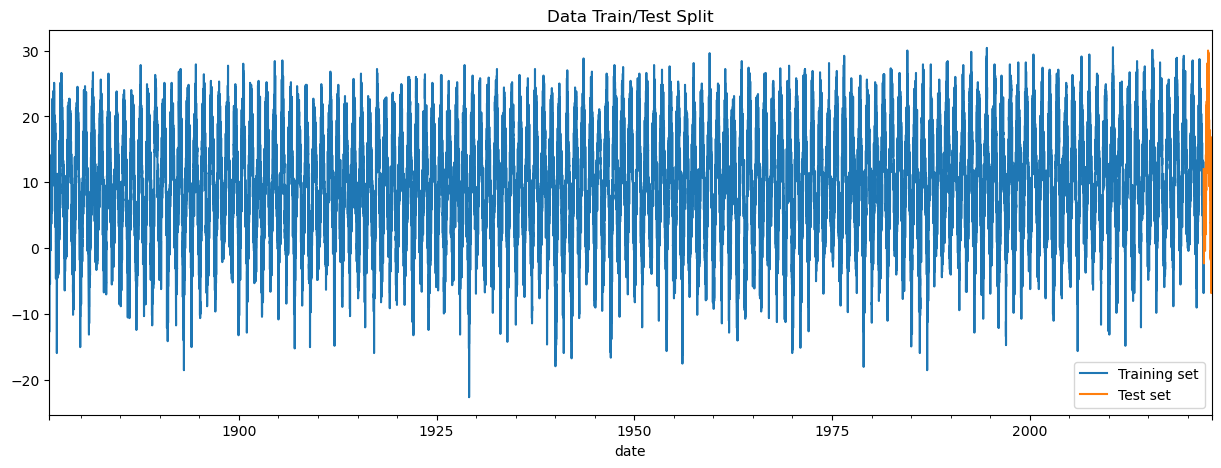

In [22]:
# plot train/test split
fig, ax = plt.subplots(figsize=(15,5))
train.plot(y='temp', ax=ax, label='Training set', title='Data Train/Test Split')
test.plot(y='temp', ax=ax, label='Test set')
plt.show()

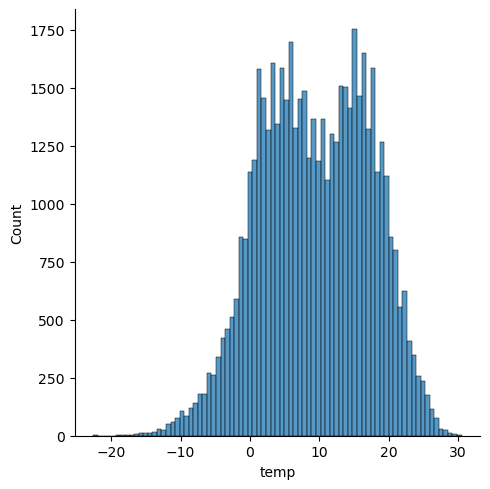

In [23]:
# distribution
sns.displot(data=train, x='temp')

Plot the rolling mean every 25years to see the trend

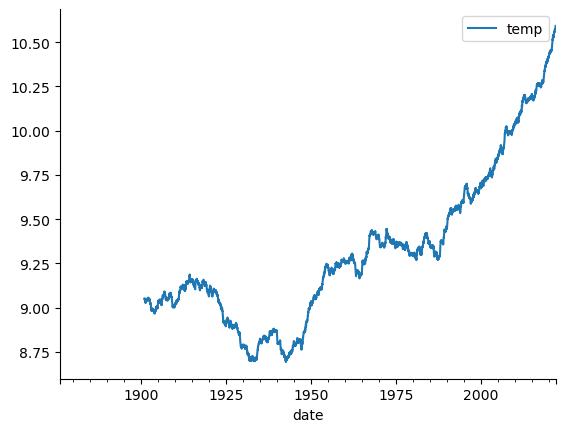

In [24]:
fts.rolling_mean_plot(train['temp'],25)

<Axes: xlabel='date'>

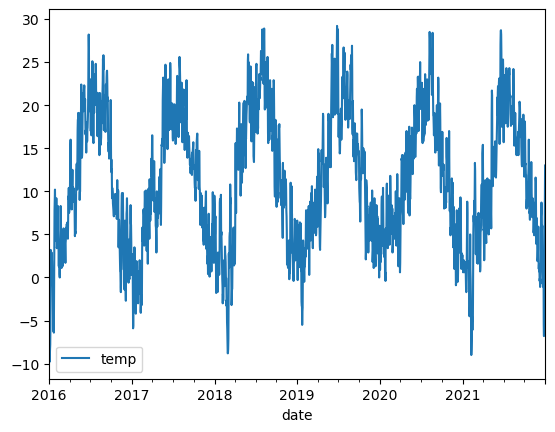

In [25]:
# plot last 5 years of data
train.loc['2016-01-01':'2021-12-31'].plot()

## 5) Feature Engineering - Baseline Model

### Decomposition of original data
We can get the decomposition by using seasonal_decomposition.
The decomposition process typicall involves the following steps:
- Trend extraction
- Seasonal extraction
- Residual extraction

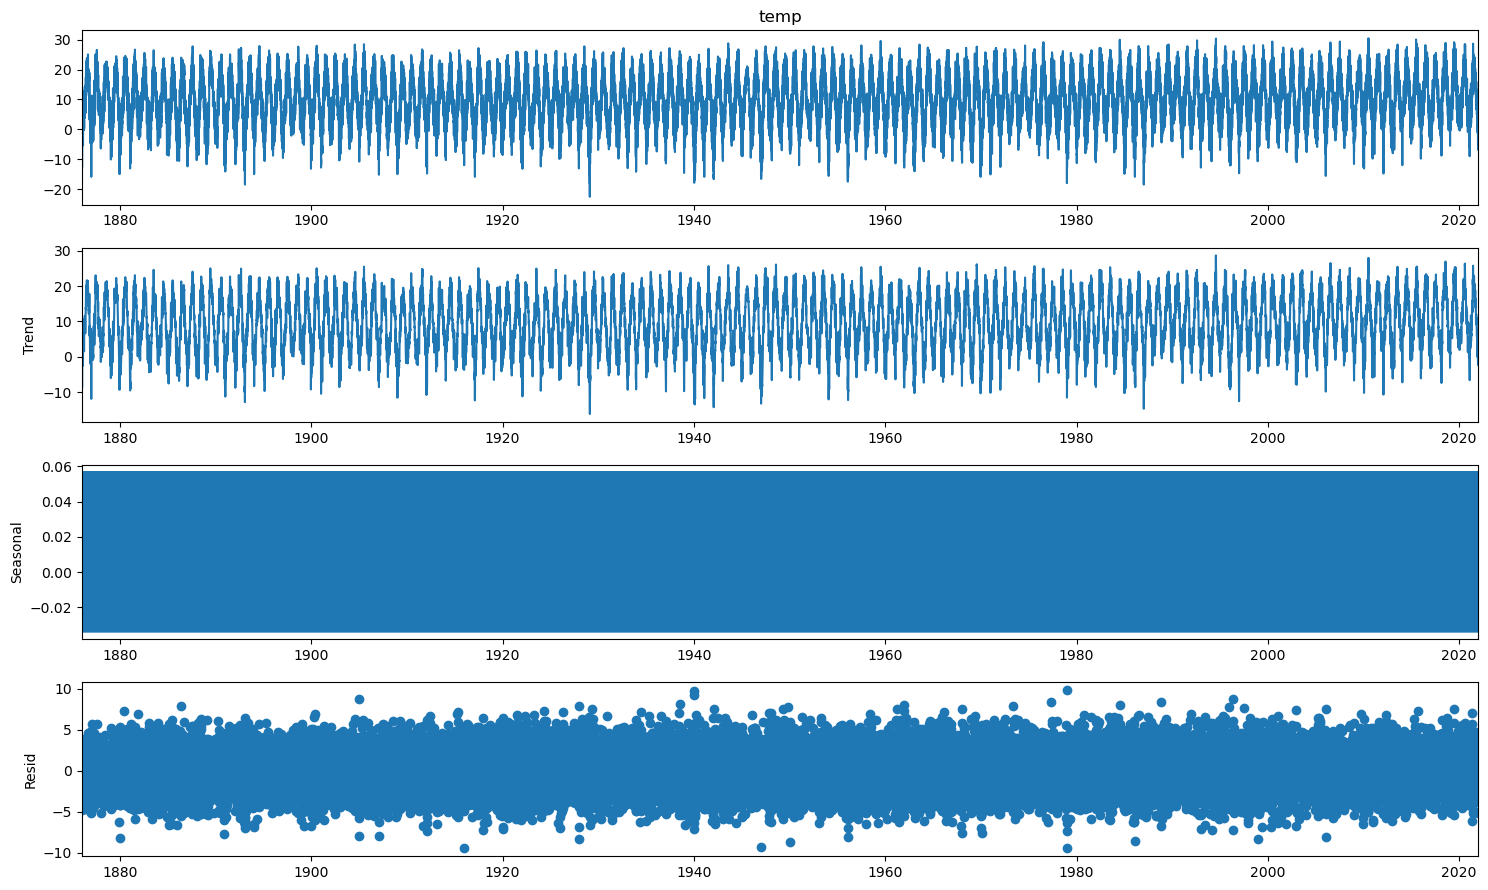

In [26]:
# hard to see because of too many data

from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(train['temp'], model='additive')

plt.rcParams['figure.figsize'] = (15,9)
sd.plot();

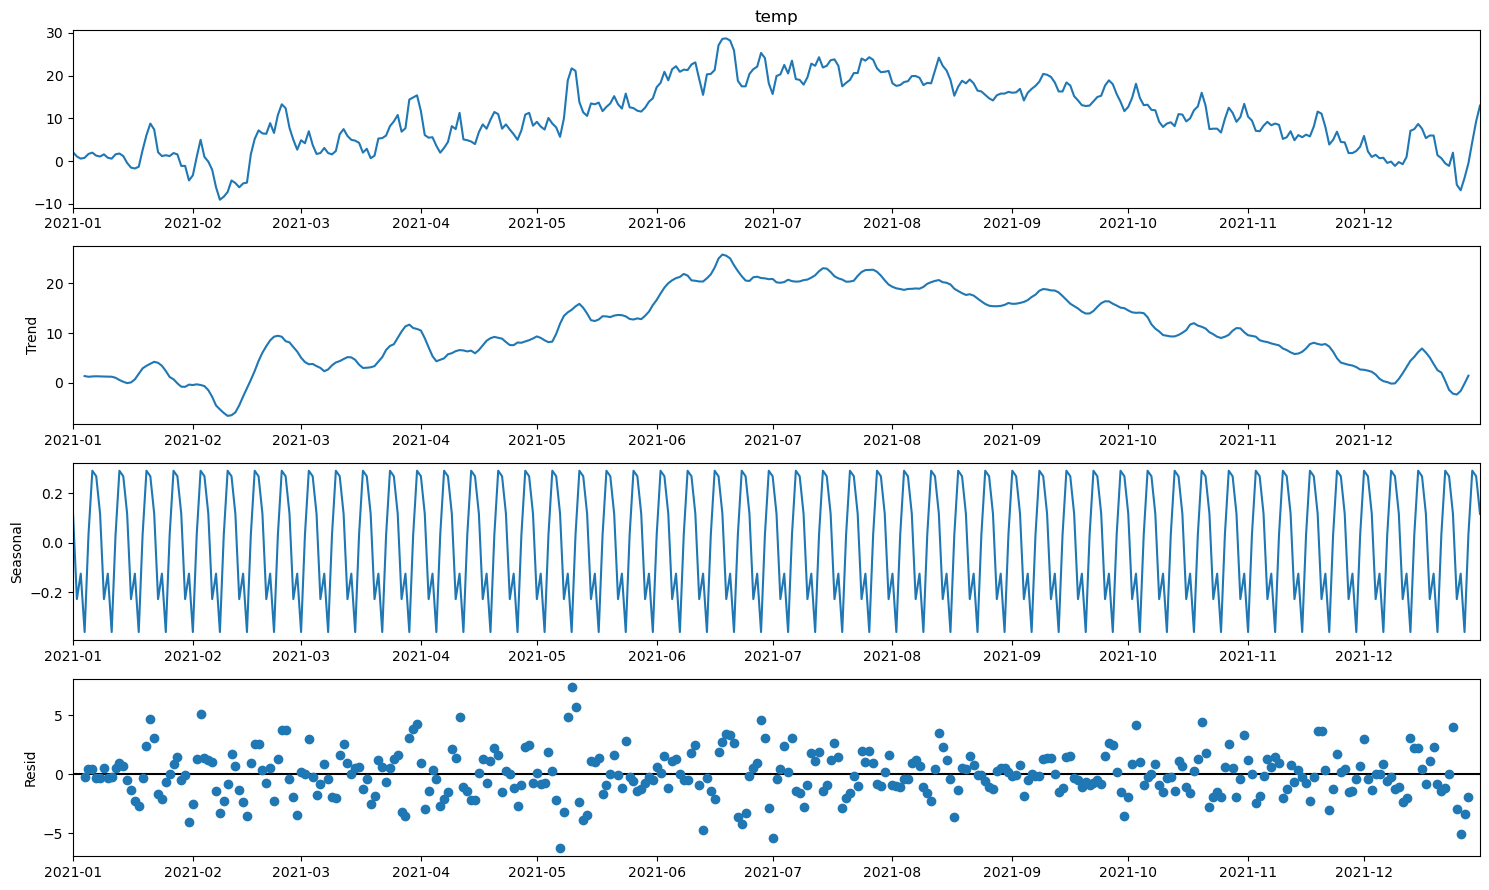

In [27]:
# one year of data 
sd = seasonal_decompose(train.loc['2021-01-01':'2021-12-31']['temp'], model='additive')

plt.rcParams['figure.figsize'] = (15,9)
sd.plot();

### 5.1) Denoise data
As you can see from the plots above that the data looks noisy, let's proceed to denoise the data <br/>

In [28]:
from scipy.signal import savgol_filter
def feature_engr_df(df):
    df['day'] = df.index.day_of_year
    df['month'] = df.index.month
    df['timestep'] = list(range(df.shape[0]))
    df['denoised'] = savgol_filter(np.array(df['temp']), 99, 3, mode='nearest')
    df['noise'] = df['temp'] - df['denoised']
    return df

In [29]:
df_feat_engr = feature_engr_df(train)
train.merge(df_feat_engr)
train

,temp,day,month,timestep,denoised,noise
date,,,,,,
1876-01-01,2.2,1,1,0,-0.659391,2.859391
1876-01-02,2.5,2,1,1,-0.772946,3.272946
1876-01-03,0.3,3,1,2,-0.858296,1.158296
1876-01-04,-5.8,4,1,3,-1.025494,-4.774506
1876-01-05,-9.8,5,1,4,-1.151521,-8.648479
...,...,...,...,...,...,...
2021-12-27,-3.9,361,12,53321,6.336164,-10.236164
2021-12-28,-0.5,362,12,53322,6.576240,-7.076240
2021-12-29,4.5,363,12,53323,6.820243,-2.320243


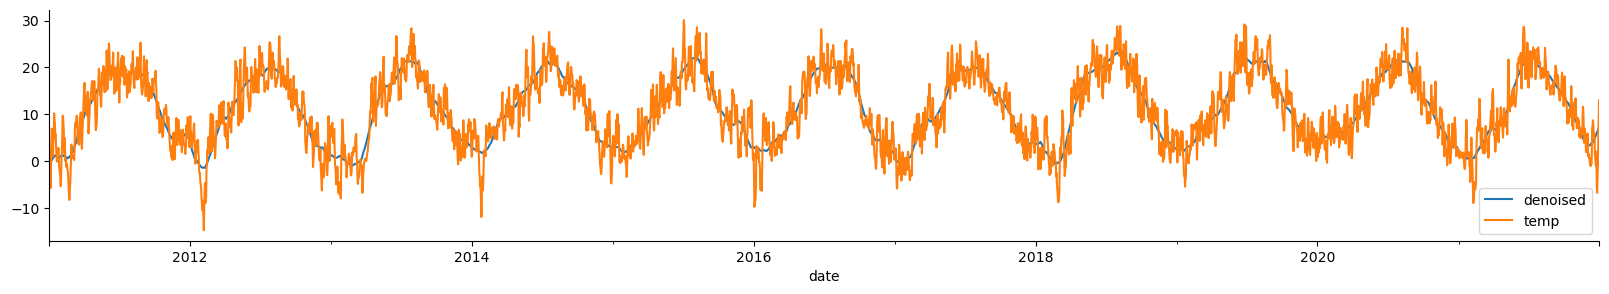

In [30]:
# denoise and temp
mpl.rc('figure',figsize=(20,3),dpi=100)
train['2011':'2021'][['denoised','temp']].plot(legend=True)

sns.despine()

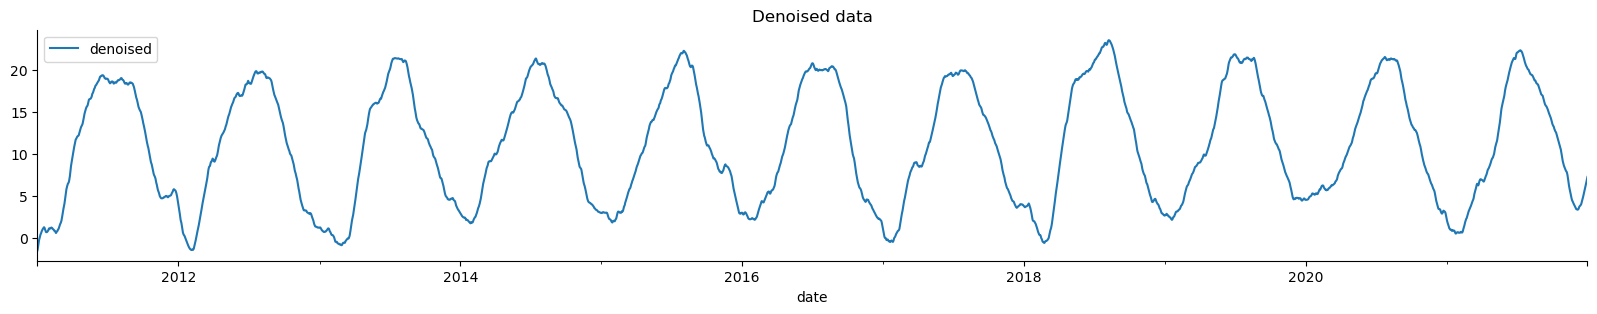

In [31]:
# plot denoised data
mpl.rc('figure',figsize=(20,3),dpi=100)
train['2011':'2021'][['denoised']].plot(legend=True,title='Denoised data')

sns.despine()

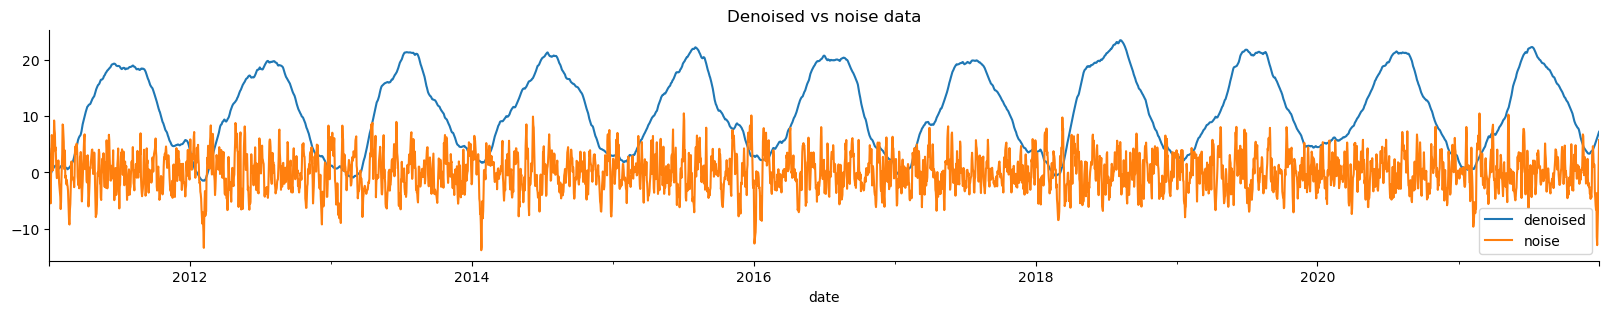

In [32]:
# plot denoised data
mpl.rc('figure',figsize=(20,3),dpi=100)
train['2011':'2021'][['denoised','noise']].plot(legend=True,title='Denoised vs noise data')

sns.despine()

### 5.2) Baseline Model

### Model with denoised data

#### a. Trend model

In [33]:
# feature and target for trend model

X_trend_denoised = train[['timestep']]
y_trend_denoised = train['denoised']

In [34]:
# trend model

trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [35]:
# fit denoised model for trend
trend_model.fit(X_trend_denoised, y_trend_denoised)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [36]:
# predict
train['trend_denoised'] = trend_model.predict(X_trend_denoised)

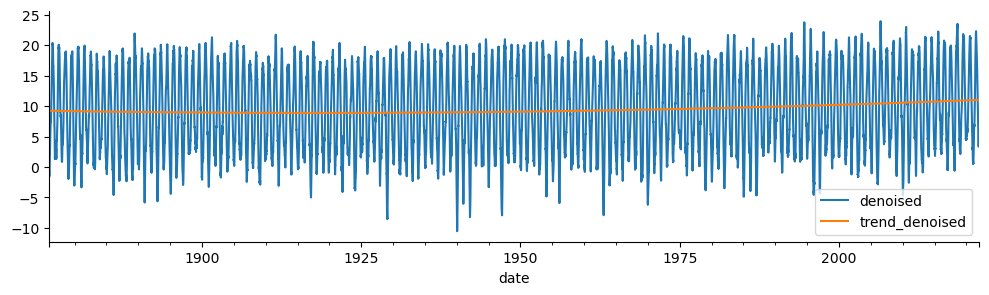

In [37]:
# plot predicted and original trend

mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','trend_denoised']].plot(legend=True)
sns.despine()

#### Detrended data (Remove trend)

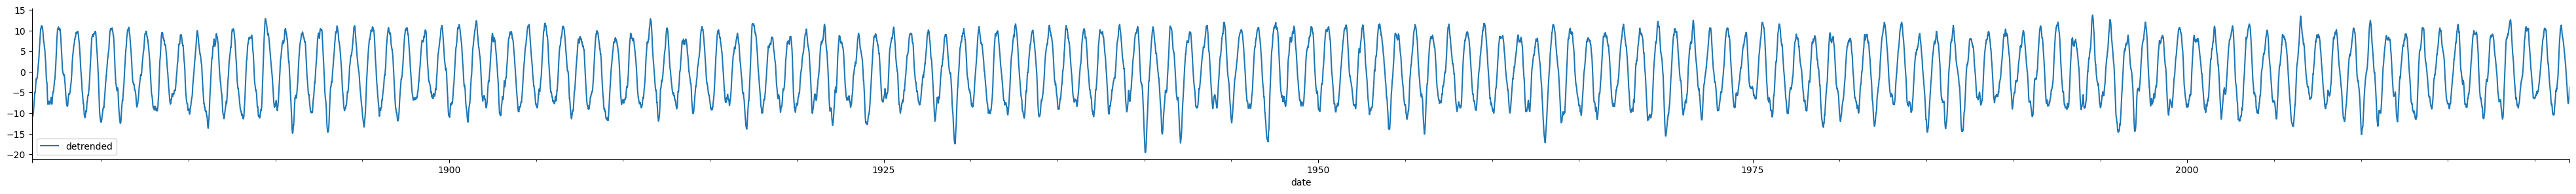

In [38]:
train['detrended'] = train['denoised'] - train['trend_denoised']
mpl.rc('figure',figsize=(50,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

#### b. Seasonality Model

In [39]:
# feature and target for seasonality model

X_seasonality = train[['day']]
y_seasonality = train['detrended']

In [40]:
# seasonality model

seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [41]:
# fit model

seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [42]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

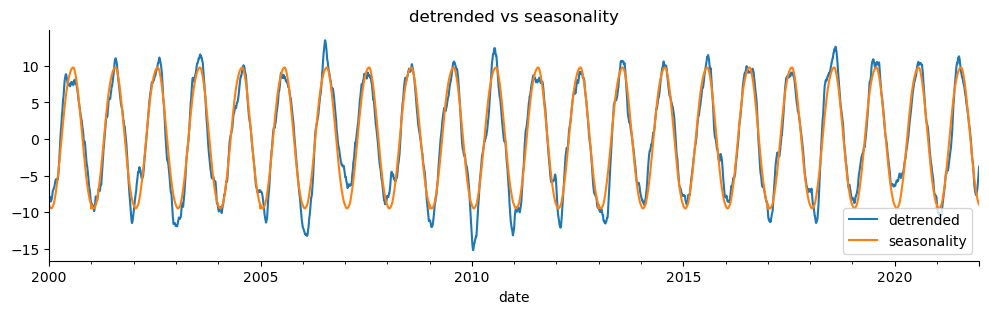

In [43]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['2000':'2021'][['detrended','seasonality']].plot(legend=True,title='detrended vs seasonality')
sns.despine()

#### Plot trend + seasonality and original data

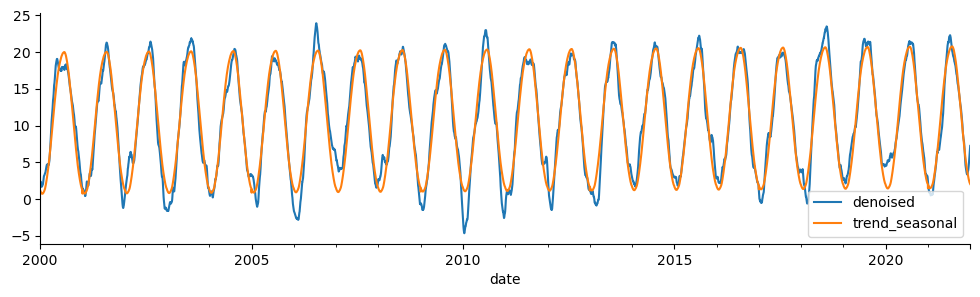

In [44]:
# combine trend and seasonality

train['trend_seasonal'] = train['trend_denoised'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train['2000':'2021'][['denoised','trend_seasonal']].plot(legend=True)
sns.despine()

In [45]:
train[['temp','trend_seasonal','denoised']].tail()

,temp,trend_seasonal,denoised
date,,,
2021-12-27,-3.9,2.190073,6.336164
2021-12-28,-0.5,2.160399,6.576240
2021-12-29,4.5,2.124181,6.820243
2021-12-30,9.3,2.084370,7.019778
2021-12-31,13.0,2.039658,7.228500


#### c. Extract remainder

In [46]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['denoised'] - train['trend_seasonal']

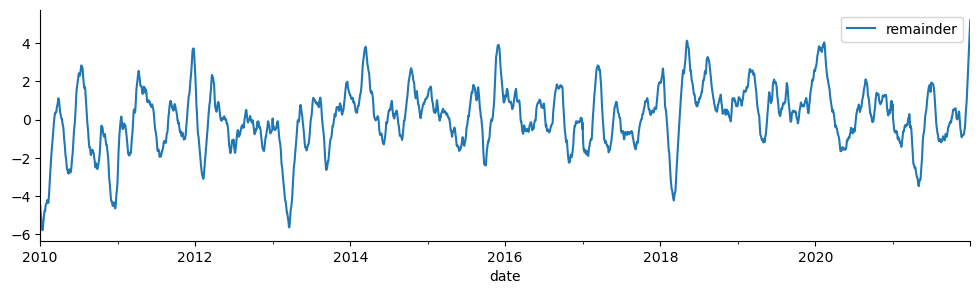

In [47]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['2010':'2021']['remainder'].plot(legend=True)
sns.despine()

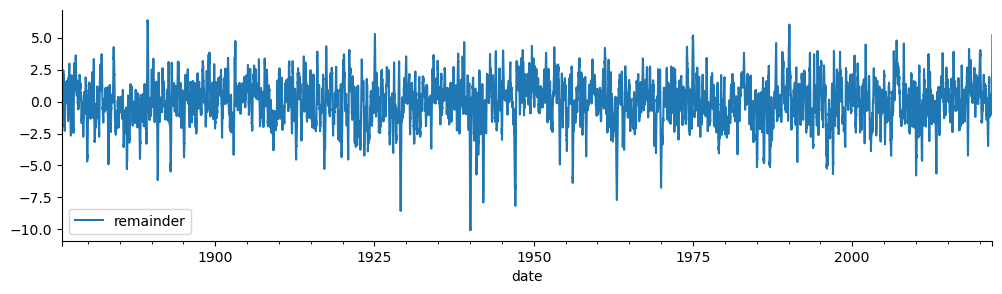

In [48]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

[qcd](https://en.wikipedia.org/wiki/Quartile_coefficient_of_dispersion)

In [49]:
# quartile coefficient of dispersion

fts.qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.755669


In [50]:
train['remainder']

date
1876-01-01   -0.814870
1876-01-02   -0.891851
1876-01-03   -0.938693
1876-01-04   -1.070704
1876-01-05   -1.165855
                ...   
2021-12-27    4.146090
2021-12-28    4.415841
2021-12-29    4.696062
2021-12-30    4.935407
2021-12-31    5.188842
Name: remainder, Length: 53326, dtype: float64

**Export noise and remainder in file**

In [51]:
remainder = train[['remainder','noise']].reset_index()
remainder.to_csv('../data/remainder_and_noise.csv',index=False)

# noise = train['noise'].reset_index()
# noise.to_csv('../data/noise.csv',index=False)

## 6) Model the remainder and noise

### 6.1) Get data

In [52]:
df = pd.read_csv(
    "../data/remainder_and_noise.csv",
    index_col=0, 
    parse_dates=True)
df.head()

,remainder,noise
date,,
1876-01-01,-0.814870,2.859391
1876-01-02,-0.891851,3.272946
1876-01-03,-0.938693,1.158296
1876-01-04,-1.070704,-4.774506
1876-01-05,-1.165855,-8.648479


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53326 entries, 1876-01-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   remainder  53326 non-null  float64
 1   noise      53326 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


### 6.2) Explore data
#### 6.2.1) Plot remainder

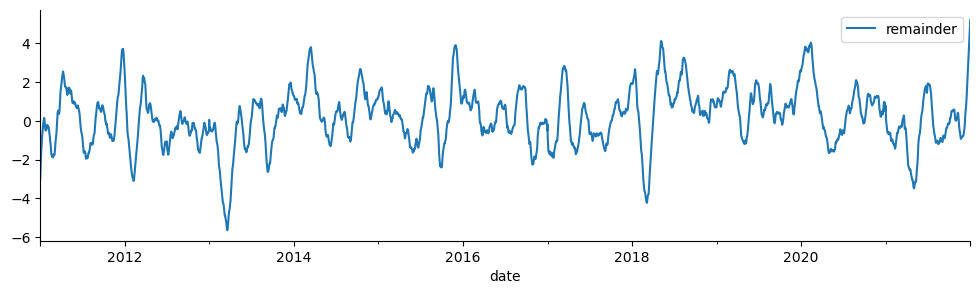

In [54]:
# get a portion of the dataset for plotting

mpl.rc('figure',figsize=(12,3),dpi=100)

train.loc['2011':'2021']['remainder'].plot(legend=True)
sns.despine()

#### 6.2.2) Check homoscedasticity

In [55]:
# quartile coefficient of dispersion

fts.qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.755669


#### 6.2.3) Check stationarity
**What Is Stationarity?** <br/>
Stationarity describes the concept that how a time series is changing will remain the same in the future. In mathematical terms, a time series is stationary when its statistical properties are independent of time:
- constant mean,
- constant variance,
- and covariance is independent of time.

**Why Is Stationarity Important?**<br/>
Some time series forecasting models (e.g., autoregressive models) require a stationary time series because they are easier to model due to their constant statistical properties. Thus, you should make your time series stationary if it is not

https://towardsdatascience.com/stationarity-in-time-series-a-comprehensive-guide-8beabe20d68

##### Tools for stationarity test 
- Augmented Dickey-Fuller (ADF)
    - null hypothesis: unit root exists (non-stationary)
    - leaves room for difference stationarity and seasonality
- Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
    - null hypotheisis: stationary up to a deterministic trend
    - often complements ADF in stationarity test 
<br/>Definition referenced from encounter notes

In [56]:
fts.test_stationarity(train['remainder'])


 non-stationary: heteroscedastic (White test p-value: 0.0) 



In [57]:
# code from online website
fts.check_stationarity_adf(train['remainder'])

ADF Statistic: -19.304318
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


#### 6.2.4) (Partial) Autocorrelation Function (ACF & PACF)

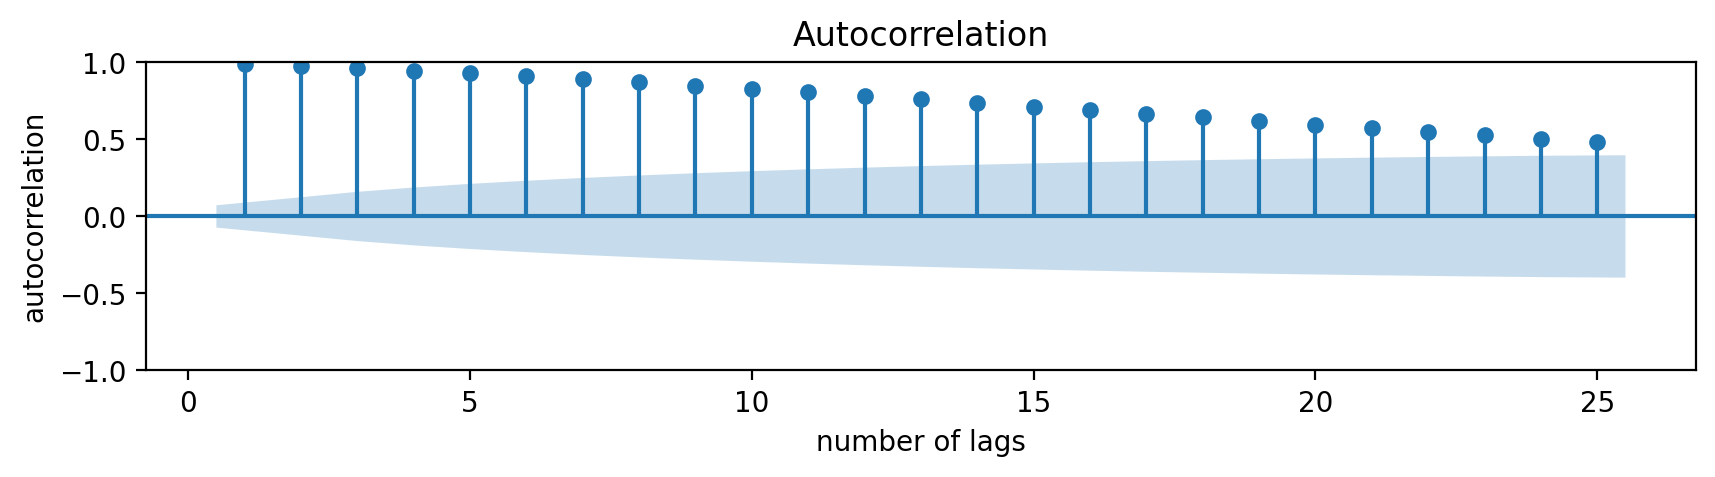

In [58]:
fts.auto_correlation_plot(train['2020':'2021'][['remainder']])

# from statsmodels.graphics.tsaplots import plot_pacf

# print(plot_pacf(train['2020':'2021'][['remainder']]))

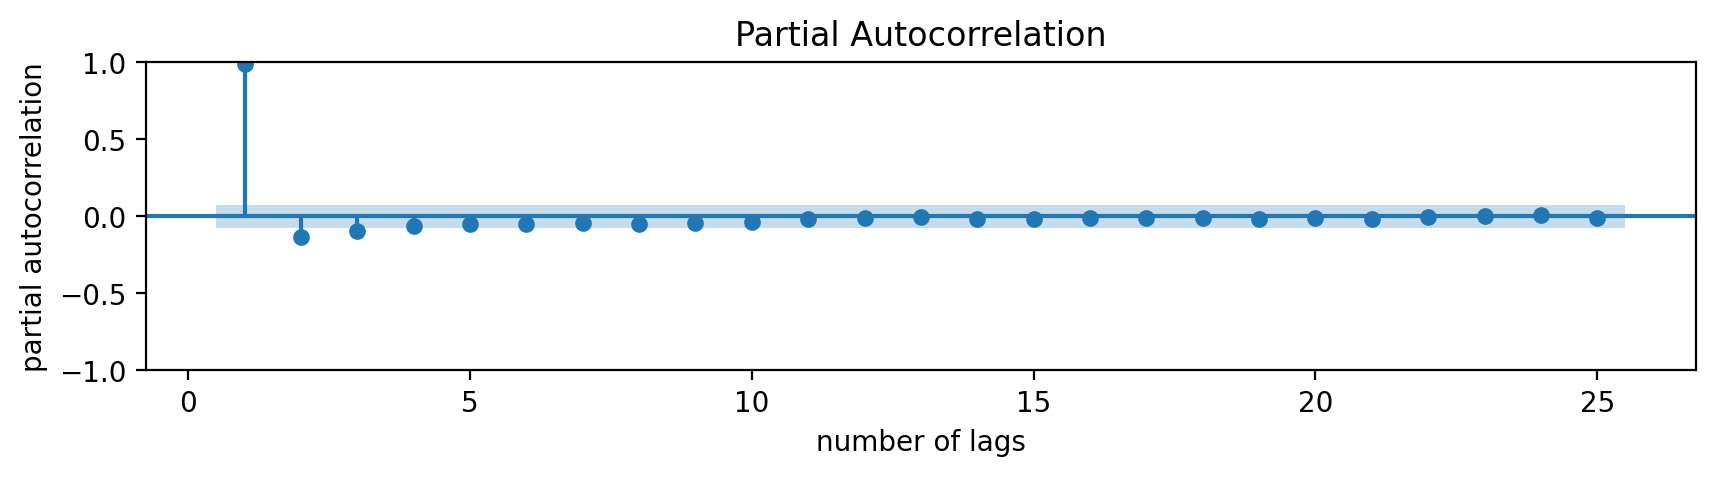

In [59]:
# fts.partial_auto_correlation_plot(train['remainder'])
fts.partial_auto_correlation_plot(train['2020':'2021'][['remainder']])


### 6.3) Model the remainder and noise
Use ARMA model to determine the best hyperparameters to use in fitting

#### a. Remainder

In [60]:
train['remainder']

date
1876-01-01   -0.814870
1876-01-02   -0.891851
1876-01-03   -0.938693
1876-01-04   -1.070704
1876-01-05   -1.165855
                ...   
2021-12-27    4.146090
2021-12-28    4.415841
2021-12-29    4.696062
2021-12-30    4.935407
2021-12-31    5.188842
Name: remainder, Length: 53326, dtype: float64

In [61]:
import pmdarima as pm

In [62]:
# Use only AR and MA for model selection

remainder_arma_model = pm.auto_arima(
    train['remainder'],
    start_p = 0,
    start_q = 0,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=209810.002, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=137435.322, Time=7.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209808.002, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-129285.398, Time=7.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-155072.197, Time=12.41 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-154744.030, Time=2.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-155114.668, Time=34.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-155034.659, Time=3.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-155144.848, Time=53.53 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-155134.279, Time=5.26 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-155205.372, Time=25.72 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-155328.406, Time=6.41 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-155330.400, Time=3.06 s

**Fit remainder using the best model**

In [63]:
remainder_arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53326
Model:               SARIMAX(5, 0, 0)   Log Likelihood               77671.200
Date:                Mon, 17 Jul 2023   AIC                        -155330.400
Time:                        14:04:57   BIC                        -155277.095
Sample:                    01-01-1876   HQIC                       -155313.752
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7435      0.002    785.601      0.000       1.739       1.748
ar.L2         -0.7079      0.003   -218.294      0.000      -0.714      -0.702
ar.L3         -0.0405      0.006     -6.308      0.000      -0.053      -0.028
ar.L4          0.0622      0.008      7.353      0.000       0.046       0.079
ar.L5         -0.0606      0.004    -13.781      0.000      -0.069      -0.052
sigma2         0.0032   8.53e-06    372.546      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):           3190297.31
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -1.66
Prob(H) (two-sided):                  0.02   Kurtosis:                        40.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

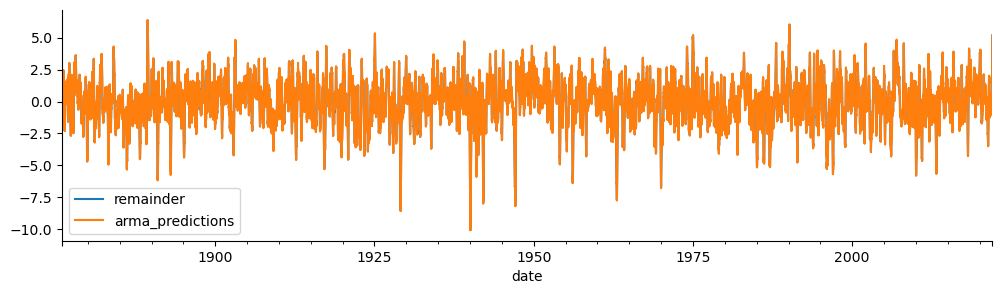

In [64]:
train['arma_predictions'] = remainder_arma_model.predict_in_sample()

# Plot original remainder and prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['remainder','arma_predictions']].plot(legend=True)
sns.despine()

In [65]:
train['residual_ar'] = train['remainder'] - train['arma_predictions']

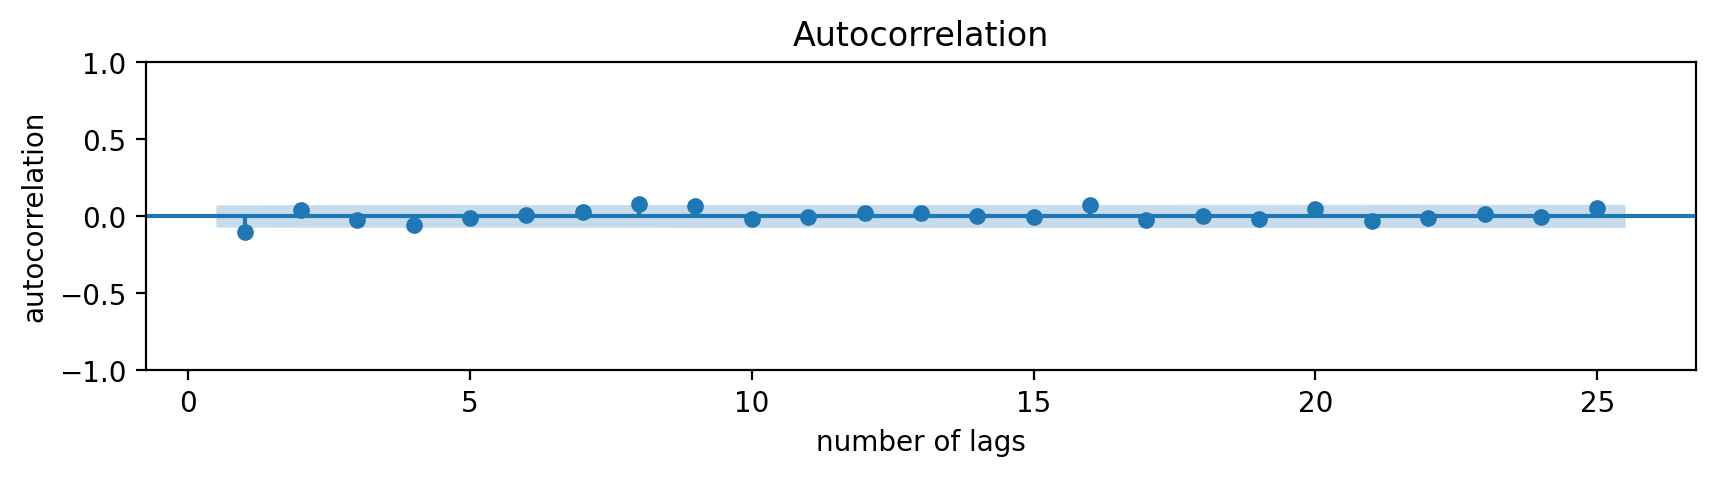

In [66]:
fts.auto_correlation_plot(train['2020':'2021'][['residual_ar']])

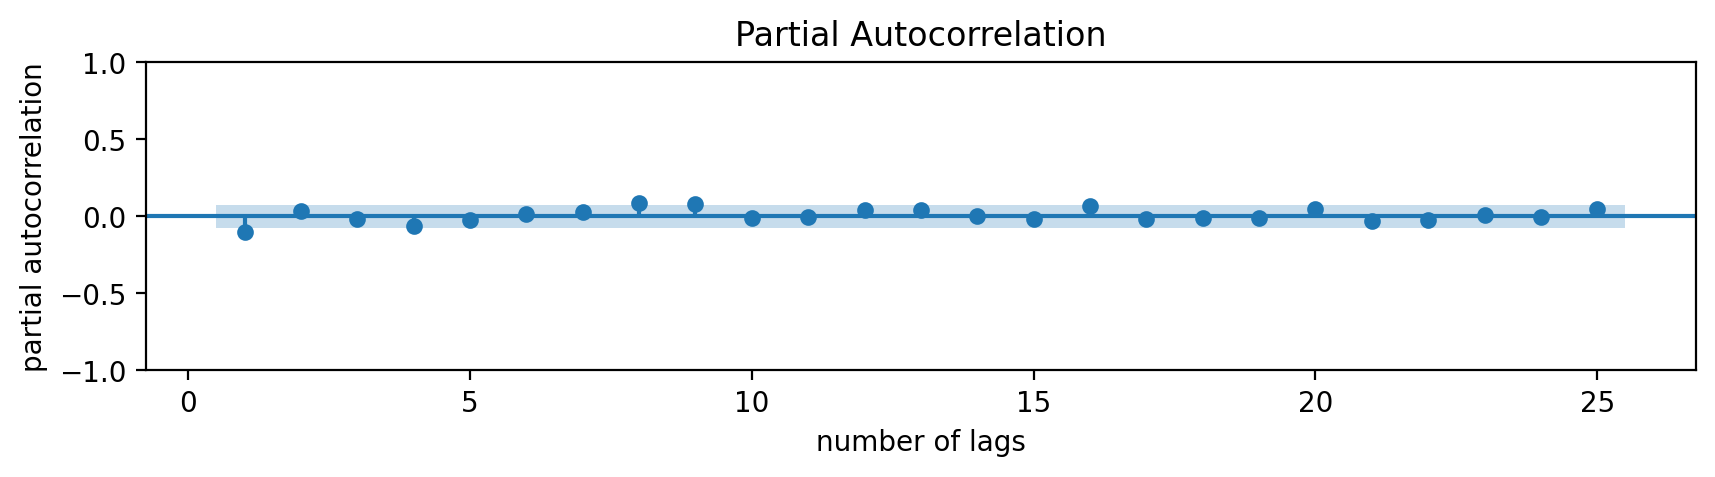

In [67]:
fts.partial_auto_correlation_plot(train['2020':'2021'][['residual_ar']])

Based on the plot above, the residual after ARMA are not useful anymore or can be considered as garbage. We don't have to do anything further with it.

#### b. Noise

In [68]:
# Use only AR and MA for model selection

noise_arma_model = pm.auto_arima(
    train['noise'],
    start_p=0,
    start_q=0,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=279168.146, Time=0.93 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=236367.977, Time=1.90 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=247226.137, Time=3.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=279166.158, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=234683.193, Time=2.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=234621.804, Time=3.72 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=234598.801, Time=4.07 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=234581.200, Time=5.81 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=71.23 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=61.58 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=234579.201, Time=2.86 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=234596.803, Time=2.27 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=29.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=27.18 sec

Best model:  ARIMA(5,0,0)(0,

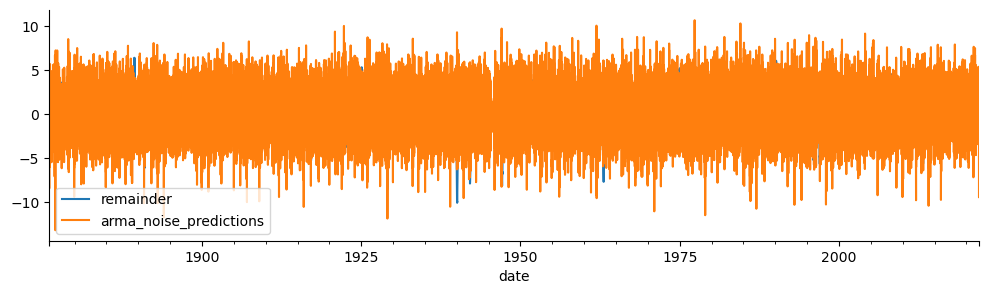

In [69]:
train['arma_noise_predictions'] = noise_arma_model.predict_in_sample()

# Plot original remainder and prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['remainder','arma_noise_predictions']].plot(legend=True)
sns.despine()

### 6.4) Complete Model

**total prediction**

In [70]:
train['total_pred'] = train['trend_seasonal'] + train['arma_predictions']

In [71]:
train['total_pred_noise'] = train['trend_seasonal'] + train['arma_noise_predictions'] + train['arma_predictions']

In [72]:
train[['denoised','total_pred','temp','total_pred_noise']].tail(20)

,denoised,total_pred,temp,total_pred_noise
date,,,,
2021-12-12,3.801729,3.776179,1.0,0.537648
2021-12-13,3.864264,3.841451,7.1,2.206289
2021-12-14,3.920969,3.904139,7.5,7.229736
2021-12-15,4.035594,3.959185,8.7,6.387934
2021-12-16,4.203383,4.105732,7.6,7.719232
2021-12-17,4.367759,4.323623,5.4,6.549649
2021-12-18,4.512491,4.489577,6.0,4.836651
2021-12-19,4.685232,4.620393,6.0,5.790381
2021-12-20,4.919447,4.811826,1.4,5.602366


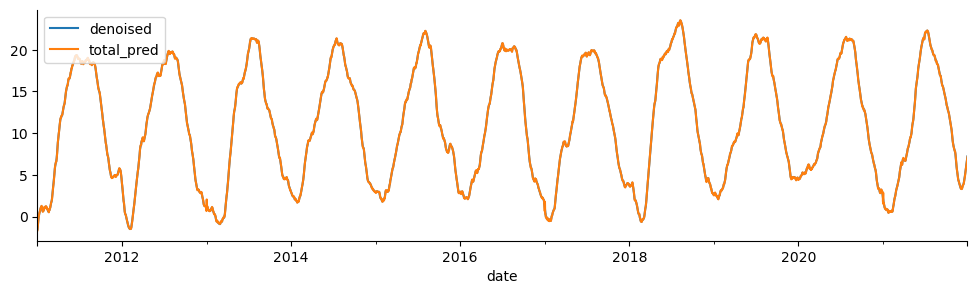

In [73]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['2011':'2021'][['denoised','total_pred']].plot(legend=True)
sns.despine()

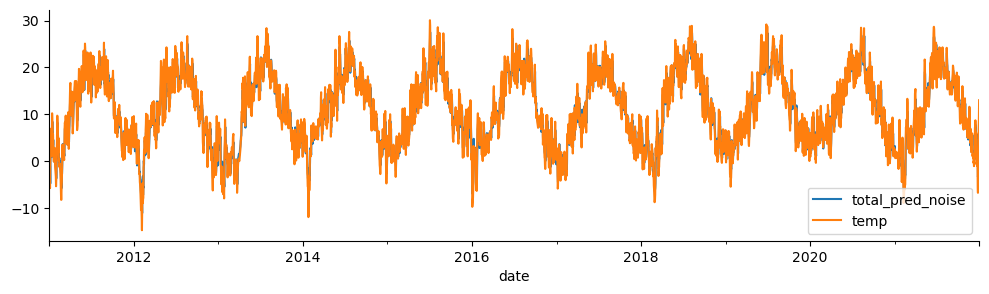

In [74]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['2011':'2021'][['total_pred_noise','temp']].plot(legend=True)
sns.despine()

### Forecast

**Denoise**

In [76]:
test.head()

,temp
date,
2022-01-01,12.0
2022-01-02,9.9
2022-01-03,8.9
2022-01-04,6.4
2022-01-05,3.8


In [77]:
test_feat_engr = feature_engr_df(test)
test.merge(test_feat_engr)
test.head()

,temp,day,month,timestep,denoised,noise
date,,,,,,
2022-01-01,12.0,1,1,0,7.620011,4.379989
2022-01-02,9.9,2,1,1,7.451507,2.448493
2022-01-03,8.9,3,1,2,7.281943,1.618057
2022-01-04,6.4,4,1,3,7.113260,-0.713260
2022-01-05,3.8,5,1,4,6.937163,-3.137163


In [ ]:
test_pred = test.copy()

test_pred['timestep'] = list(range(53326,53326+test.shape[0]))
test_pred = test_pred.loc[:,['timestep']]
test_pred

In [ ]:
X_trend_test_denoised = test_pred[['timestep']]
test_pred['trend_denoised'] = trend_model.predict(X_trend_test_denoised)

**Trend**

In [78]:
# predict
X_trend_test_denoised = test[['timestep']]
test['trend_denoised'] = trend_model.predict(X_trend_test_denoised)

**Detrended**

In [ ]:
#test['detrended'] = test['denoised'] - test['trend_denoised']

**Seasonality**

In [79]:
X_test_seasonality = test[['day']]
test['seasonality'] = seasonality_model.predict(X_test_seasonality)

**Trend seasonal**

In [80]:
test['trend_seasonal'] = test['trend_denoised'] + test['seasonality']

**Remainder**

In [ ]:
test

In [81]:

# test['arma_predictions'] = remainder_arma_model.predict(remainder_test.shape[0], return_conf_int=True)[0]

test['arma_predictions'] = remainder_arma_model.predict(20, return_conf_int=True)[0]

In [82]:
# test['arma_noise_predictions'] = noise_arma_model.predict(noise_test.shape[0], return_conf_int=True)[0]
test['arma_noise_predictions'] = noise_arma_model.predict(20, return_conf_int=True)[0]

In [84]:
test['total_pred_new'] = test['trend_seasonal'] + test['arma_predictions'] + test['arma_noise_predictions']

In [85]:
test['2022-01-01':'2022-01-10'][['temp','total_pred_new']].head(20)

,temp,total_pred_new
date,,
2022-01-01,12.0,10.258699
2022-01-02,9.9,8.860605
2022-01-03,8.9,7.886775
2022-01-04,6.4,7.175814
2022-01-05,3.8,6.619260
2022-01-06,1.2,6.240355
2022-01-07,0.7,6.007475
2022-01-08,1.3,5.860951
2022-01-09,1.5,5.757064


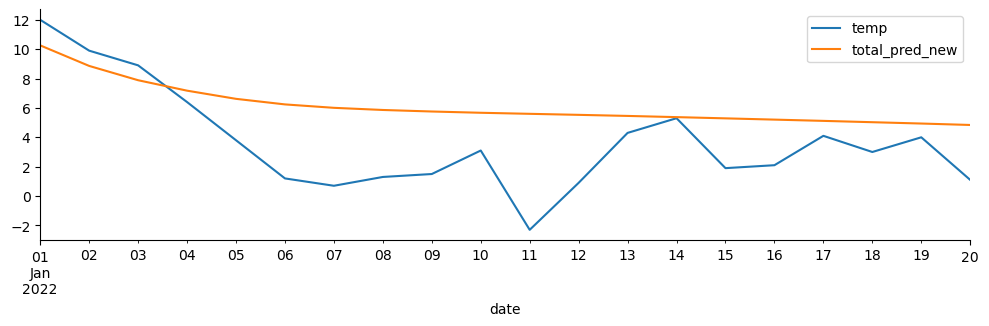

In [86]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test['2022-01-01':'2022-01-20'][['temp','total_pred_new']].plot(legend=True)
sns.despine()